In [ ]:
from pathlib import Path
from random import randint
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import pandas as pd
from rectools import Columns
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import faiss
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [270]:
DATA_PATH = Path("/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/kion_train")
users_df = pd.read_csv(DATA_PATH / 'users.csv')
items_df = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

In [271]:
interactions.shape

(5476251, 5)

In [272]:
interactions_df = interactions.drop(columns='total_dur')
interactions_df['watched_pct'] = interactions_df['watched_pct'] / 100
interactions_df.rename(columns={'user_id': Columns.User, 'item_id': Columns.Item,
                                'last_watch_dt': Columns.Datetime, 'watched_pct': Columns.Weight}, inplace=True)
interactions_df.dropna(inplace=True)

### Избавляемся от пропущенных значений

In [273]:
mask = items_df.isnull().mean() > 0
items_df.isnull().mean()[mask]

title_orig      0.297250
release_year    0.006139
countries       0.002318
for_kids        0.964543
age_rating      0.000125
studios         0.933283
directors       0.094531
actors          0.164067
description     0.000125
keywords        0.026499
dtype: float64

Удалю колнки с большим количестовм пропусков + в остальных случаях удалю строки

In [274]:
print(items_df.shape)
items_df = items_df[['item_id', 'release_year', 'countries', 'age_rating', 'directors', 'description']]
items_df = items_df.dropna(axis=0)
print(items_df.shape)

(15963, 14)
(14451, 6)


In [275]:
print(users_df.shape)
mask = users_df.isnull().mean() > 0
users_df.isnull().mean()[mask]
users_df = users_df.dropna(axis=0)
print(users_df.shape)

(840197, 5)
(818683, 5)


### Отфильтрую пользователей

In [276]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

interactions_df = interactions_df[interactions_df.weight > 0.1]

valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 10:
        valid_users.append(user_id)

valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962151
N items before: 15605

N users after: 79515
N items after: 6901


In [277]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_df.item_id.unique()))

interactions_df = interactions_df[interactions_df.user_id.isin(common_users) & interactions_df.item_id.isin(common_items)]

common_users = set(interactions_df.user_id.unique())
common_items = set(interactions_df.item_id.unique())

users_df = users_df[users_df.user_id.isin(common_users)]
items_df = items_df[items_df.item_id.isin(common_items)]

print(f'количество user_id в interactions_df = {interactions_df.user_id.nunique()}')
print(f'количество user_id в users_df = {users_df.user_id.nunique()}')
print(f'количество item_id в interactions_df = {interactions_df.item_id.nunique()}')
print(f'количество item_id в items_df = {items_df.item_id.nunique()}')

количество user_id в interactions_df = 65024
количество user_id в users_df = 65024
количество item_id в interactions_df = 6691
количество item_id в items_df = 6691


In [278]:
interactions_df = interactions_df.reset_index(drop=True)
users_df = users_df.reset_index(drop=True)
items_df = items_df.reset_index(drop=True)

## Готовлю фичи

### Фичи для пользователя

In [279]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()

,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
0,721985,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
1,269408,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
2,384532,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,723106,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
4,216495,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0


### Фичи для айтема

In [280]:
def categorize_popularity(popularity):
    if popularity >= 0.75:
        return 'High Popularity'
    elif popularity >= 0.4:
        return 'Medium Popularity'
    else:
        return 'Low Popularity'

items_df['directors'] = items_df['directors'].str.split(', ')
items_df_exploded = items_df.explode('directors')
interactions_directors = interactions_df.merge(items_df_exploded, on='item_id')
director_popularity = interactions_directors.groupby('directors')['weight'].mean().reset_index()
director_popularity['director_category'] = director_popularity['weight'].apply(categorize_popularity)
items_df_exploded = items_df_exploded.merge(director_popularity, on='directors', how='left')
grouped = items_df_exploded.groupby(items_df_exploded.index)
items_df['directors_cat'] = grouped['director_category'].agg(lambda x: ', '.join(x.dropna().unique()))

In [281]:
item_cat_feats = ['age_rating', 'directors_cat']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1)


min_year = items_df['release_year'].min()
max_year = items_df['release_year'].max()
items_df['release_year'] = (items_df['release_year'] - min_year) / (max_year - min_year)


items_ohe_df.head()

,item_id,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,age_rating_21.0,directors_cat_High Popularity,directors_cat_Low Popularity,directors_cat_Medium Popularity
0,9853,0,0,0,1,0,0,1,0,0
1,3526,0,0,0,0,1,0,0,0,1
2,15076,0,0,0,0,1,0,0,0,1
3,2904,0,0,0,0,1,0,1,0,0
4,1622,0,0,1,0,0,0,1,0,0


1 - 0.75
0.75 - 0.40
0.40 - 0

In [282]:
items_df['countries'] = items_df.countries.str.split(',')
mlb = MultiLabelBinarizer()
one_hot_encoded = pd.DataFrame(mlb.fit_transform(items_df['countries']), columns=mlb.classes_)
items_ohe_df = pd.concat([items_ohe_df, one_hot_encoded], axis=1)
items_ohe_df.head()

,item_id,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,age_rating_21.0,directors_cat_High Popularity,directors_cat_Low Popularity,directors_cat_Medium Popularity,...,Франция,Хорватия,Чехия,Чили,Швейцария,Швеция,Эквадор,Эстония,ЮАР,Япония
0,9853,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3526,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,15076,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2904,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1622,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### теперь добавим текстовые признаки из описания

In [261]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [263]:
texts = items_df['description'].tolist()
text_dataset = TextDataset(texts)

batch_size = 32
data_loader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)

In [265]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
embeddings = []
with torch.no_grad():
    for batch in data_loader:
        batch_embeddings = model.encode(batch, convert_to_tensor=True)
        embeddings.append(batch_embeddings.cpu().numpy())

In [ ]:
embeddings = np.concatenate(embeddings)
items_df['description_emb'] = list(embeddings)

In [ ]:
exploded_df = items_df['description_emb'].apply(pd.Series)

In [ ]:
items_ohe_df = pd.concat([items_ohe_df, exploded_df], axis=1)

In [ ]:
items_ohe_df.to_csv('items_ohe_df.csv', index=False)
users_ohe_df.to_csv('users_ohe_df.csv', index=False)

загрузка полученных датафреймов с фичами


In [283]:
items_ohe_df = pd.read_csv('/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/kion_train/items_ohe_df.csv')
users_ohe_df = pd.read_csv('/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/kion_train/users_ohe_df.csv')
print(items_ohe_df.shape)
print(users_ohe_df.shape)

(6691, 533)
(65024, 17)


### Работа над матрицей взаимодействий

In [284]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()


[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,datetime,weight,uid,iid
0,176549,9506,2021-05-11,0.72,10468,3833
1,699317,1659,2021-05-29,1.00,41522,649
2,1016458,354,2021-08-14,0.25,60153,132
3,884009,693,2021-08-04,0.14,52392,270
4,5324,8437,2021-04-18,0.92,308,3391


In [285]:
interactions_vec = np.zeros((interactions_df.uid.nunique(),
                             interactions_df.iid.nunique()))

for user_id, item_id, weight in zip(interactions_df.uid, interactions_df.iid, interactions_df.weight):
    interactions_vec[user_id, item_id] += weight


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]


In [286]:
print(interactions_df.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_ohe_df.user_id.nunique())

print(set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique()))


6691
6691
65024
65024
set()


In [287]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]


In [288]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")


In [290]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)

    return loss


### Генератор и семплирование

In [292]:
def generator(items, users, interactions, batch_size=1024):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            uid_i = randint(0, interactions.shape[0]-1)
            pos_proba = interactions[uid_i]
            pos_i = np.random.choice(range(interactions.shape[1]), p=pos_proba)
            neg_indices = np.arange(interactions.shape[1])[interactions[uid_i] == 0]
            neg_i = np.random.choice(neg_indices)
            uid_meta.append(users.iloc[uid_i])
            uid_interaction.append(interactions[uid_i])
            pos.append(items.iloc[pos_i])
            neg.append(items.iloc[neg_i])

        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]

In [293]:
gen = generator(items=items_ohe_df.drop(["item_id"], axis=1),
                users=users_ohe_df.drop(["user_id"], axis=1),
                interactions=interactions_vec)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6691)
вектор 'хорошего' айтема: (1024, 532)
вектор 'плохого' айтема: (1024, 532)

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6691)


In [295]:
N_FACTORS = 128

ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], )
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (532,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (6691,)


In [298]:
def item_model(n_factors=N_FACTORS):
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)

    add = keras.layers.Add()([layer_1, layer_2])

    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)

    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)


    add = keras.layers.Add()([layer_1_meta, layer_2_meta])

    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])

    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)

    return keras.models.Model([inp_meta, inp_interaction], out)

i2v = item_model()
u2v = user_model()

ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

ancor = u2v([ancor_meta_in, ancor_interaction_in])
pos = i2v(pos_in)
neg = i2v(neg_in)

res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

In [299]:
model_name = 'recsys_resnet_linear'

t_board = keras.callbacks.TensorBoard(log_dir=f'runs/{model_name}')

decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)

check = keras.callbacks.ModelCheckpoint(filepath=model_name + '/epoch{epoch}-{loss:.2f}.h5', monitor="loss")


In [300]:
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt)


In [301]:
model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1),
                    users=users_ohe_df.drop(["user_id"], axis=1),
                    interactions=interactions_vec,
                    batch_size=64),
          steps_per_epoch=100,
          epochs=30,
          initial_epoch=0,
          callbacks=[decay, t_board, check]
)


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.4294

/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 14s 123ms/step - loss: 0.4294 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 11s 111ms/step - loss: 0.3114 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 11s 111ms/step - loss: 0.2905 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 11s 116ms/step - loss: 0.2663 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 11s 107ms/step - loss: 0.2544 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2369 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2228 - lr: 0.0010
Epoch 8/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2206 - lr: 0.0010
Epoch 9/30
100/100 [==============================] - 11s 109ms/step - loss: 0.2241 - lr: 0.0010
Epoch 10/30
100/100 [==============================] - 11s 108ms/step - loss: 0.2055 - lr: 0.0010
Epoch 11/30
100/100 [===================

In [302]:
rand_uid = np.random.choice(list(users_ohe_df.index))

user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[rand_uid]
user_interaction_vec = interactions_vec[rand_uid]

rand_iid = np.random.choice(list(items_ohe_df.index))
item_feats = items_ohe_df.drop(["item_id"], axis=1).iloc[rand_iid]

user_vec = u2v.predict([np.array(user_meta_feats).reshape(1, -1),
                        np.array(user_interaction_vec).reshape(1, -1)])

item_vec = i2v.predict(np.array(item_feats).reshape(1, -1))

from sklearn.metrics.pairwise import euclidean_distances as ED

ED(user_vec, item_vec)


1/1 [==============================] - 0s 61ms/step


array([[1.2798507]], dtype=float32)

получение значений для всех юзеров и айтемов

In [303]:
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
items_vecs = i2v.predict(items_feats)


210/210 [==============================] - 0s 1ms/step


In [304]:
users_meta_feats = users_ohe_df.drop(["user_id"], axis=1)
users_interaction_vec = interactions_vec
users_vec = u2v.predict([np.array(users_meta_feats),
                        np.array(users_interaction_vec)])

2032/2032 [==============================] - 4s 2ms/step


In [391]:
class FaissIndex:
    def __init__(self, user_id_to_uid, iid_to_item_id, users, popular, threshold=0.83,
                 dimension=128, N=10):
        self.dimension = dimension
        self.faiss_index = faiss.IndexFlatL2(self.dimension)
        faiss.omp_set_num_threads(1)
        self.N = N
        self.user_id_to_uid = user_id_to_uid
        self.iid_to_item_id = iid_to_item_id
        self.users = users
        self.popular = popular
        self.threshold = threshold

    def index(self, data):
        assert data.shape[
                   1] == self.dimension, "Размерность векторов должна соответствовать размерности индекса"
        self.faiss_index.add(data)

    def add_popular(self, item_ids):
        mask = ~np.isin(self.popular, item_ids)
        filtered_popular = self.popular[mask]
        combined = np.concatenate([item_ids, filtered_popular])
        combined = combined.astype(int)
        result = combined[:self.N]
        return result

    def get_items(self, query_user):
        query_uid = self.user_id_to_uid.get(query_user, None)
        if query_uid is None:
            return self.popular[:10].tolist()
        user_vector = self.users[query_uid]
        user_vector = user_vector.reshape(1, -1)
        assert user_vector.shape[
                   1] == self.dimension, "Размерность векторов запросов должна соответствовать размерности индекса."
        D, I = self.faiss_index.search(user_vector, self.N)
        filtered_indices = [[iid for iid, dist in zip(irow, drow) if dist <= self.threshold] for irow, drow in zip(I, D)]
        item_ids = [[self.iid_to_item_id[iid] for iid in row] for row in filtered_indices]
        item_ids = self.add_popular(item_ids[0])
        return item_ids.tolist()

    def save(self, filepath):
        faiss.write_index(self.faiss_index, filepath + "_faiss.index")

        with open(filepath + "_data.pkl", 'wb') as f:
            data = {
                "dimension": self.dimension,
                "N": self.N,
                "user_id_to_uid": self.user_id_to_uid,
                "iid_to_item_id": self.iid_to_item_id,
                "users": self.users,
                "popular": self.popular,
                "threshold": self.threshold
            }
            pickle.dump(data, f)

    @classmethod
    def load(cls, filepath):
        faiss_index = faiss.read_index(filepath + "_faiss.index")

        with open(filepath + "_data.pkl", 'rb') as f:
            data = pickle.load(f)

        instance = cls(
            user_id_to_uid=data["user_id_to_uid"],
            iid_to_item_id=data["iid_to_item_id"],
            users=data["users"],
            popular=data["popular"],
            threshold=data["threshold"],
            dimension=data["dimension"],
            N=data["N"]
        )
        instance.faiss_index = faiss_index
        return instance

In [398]:
popular = np.load('/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/service/api/recsys/models/popular.npy')
print(popular)

[15297 10440 13865  9728  4151  3734  2657   142  6809  8636  9996 11237
  4740  7571  1844  4457  7417 14431  4495  7102  7829 12192 12995 14741
 14703  7793  4436 16166  3784 16228]


In [393]:
vec_bd = FaissIndex(user_id_to_uid, iid_to_item_id, users_vec, popular)
vec_bd.index(items_vecs)

In [394]:
vec_bd.get_items(945758)

[9728, 8134, 10440, 15297, 13865, 4151, 3734, 2657, 142, 6809]

In [395]:
vec_bd.save('/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/service/api/recsys/models/DSSM')

In [396]:
loaded_vec_db = FaissIndex.load('/Users/tanchik/Desktop/Настоящее/учеба/RecSys/RecoServiceTemplate/service/api/recsys/models/DSSM')

In [397]:
loaded_vec_db.get_items(945758)

[9728, 8134, 10440, 15297, 13865, 4151, 3734, 2657, 142, 6809]

In [363]:
distances = []
for user in user_id_to_uid.keys():
    items, distances_user = vec_bd.get_items(user)
    distances += distances_user.tolist()

In [357]:
print(min(distances))
print(max(distances))
print(np.mean(distances))

0.2783535122871399
2.89692759513855
0.8369842476582734


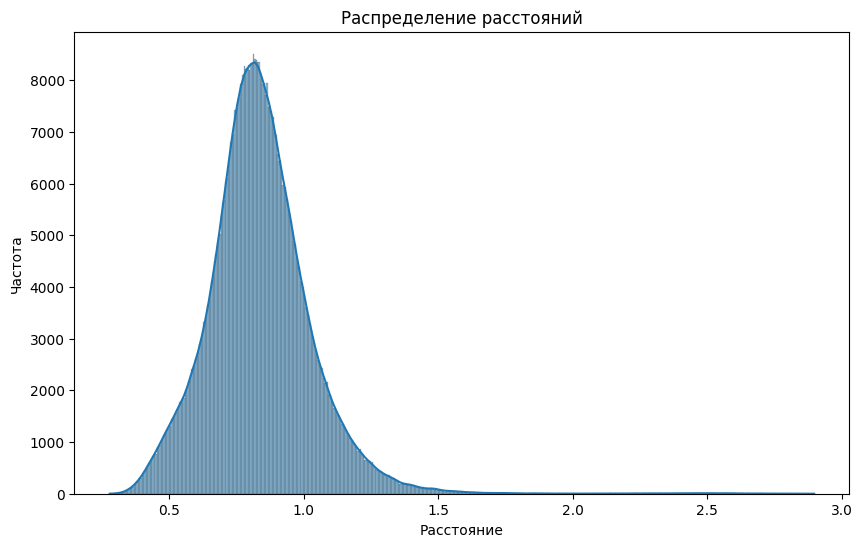

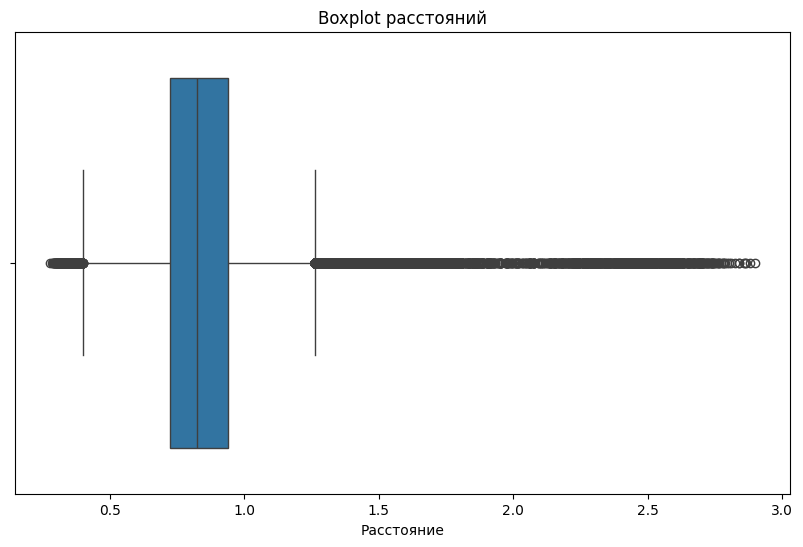

In [356]:
plt.figure(figsize=(10, 6))
sns.histplot(distances, kde=True)
plt.title('Распределение расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=distances)
plt.title('Boxplot расстояний')
plt.xlabel('Расстояние')
plt.show()